# NIM : 2209106045
# Nama : Dustin Hessel Kopalit

Dataset : [Rice Image Dataset](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset?resource=download)


Dataset ini merupakan kumpulan citra biji beras dari lima varietas berbeda, Dataset ini memiliki 5 kelas (Arborio, Basmati, Ipsala, Jasmine, dan Karacadag)

## IMPORT LIBRARY

In [29]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


## EKSTRAKSI FITUR HOG

HOG adalah teknik yang banyak digunakan dalam pengolahan citra untuk menangkap informasi bentuk dan kontur dari sebuah objek dalam gambar.

**Cara Kerja HOG:**
1. **Resizing**: Gambar diubah ukurannya menjadi 128x128 piksel untuk standarisasi input.
2. **Grayscale**: Gambar dikonversi ke grayscale karena HOG hanya memerlukan informasi struktur, bukan warna.
3. **Pembagian Sel & Blok**:
   - Gambar dibagi menjadi sel-sel kecil (8x8 piksel).
   - Setiap sel menghasilkan histogram dari arah gradien piksel (orientations = 9).
   - Blok terdiri dari 2x2 sel dan digunakan untuk normalisasi lokal (`block_norm='L2-Hys'`).
4. **Output**: Vektor fitur yang merepresentasikan arah dan kekuatan kontur lokal di seluruh citra.

#### Alasan Pemilihan HOG:
- **Menangkap struktur bentuk** objek, cocok untuk citra biji padi yang memiliki kontur dan tekstur khas.
- **Tahan terhadap pencahayaan** dan rotasi kecil.
- **Efisien secara komputasi**, terutama untuk klasifikasi berbasis SVM.


In [30]:
def extract_hog_features(image):
    image = cv2.resize(image, (128, 128))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys',
                      visualize=True)
    return features


## LOAD DATASET

In [31]:
def load_dataset_and_labels(folder_path):
    features, labels = [], []
    for label_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, label_name)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            fpath = os.path.join(class_dir, fname)
            image = cv2.imread(fpath)
            if image is None:
                continue
            image = cv2.resize(image, (128, 128))
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            hog_feature = hog(gray,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              block_norm='L2-Hys',
                              visualize=False)
            features.append(hog_feature)
            labels.append(label_name)
    return np.array(features), np.array(labels)

In [34]:
X, y = load_dataset_and_labels("D:/SEMESTER 6/VISIKOM/New folder/Rice_Image_Dataset")
le = LabelEncoder()
y_encoded = le.fit_transform(y)

## STANDARISASI FITUR

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Train-test split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

## TRAIN SVM

In [37]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

## Evaluasi Akurasi dan Confusion Matrix

In [38]:
accuracy = svm.score(X_test, y_test)
print(f"SVM Accuracy: {accuracy:.2f}")

SVM Accuracy: 0.96


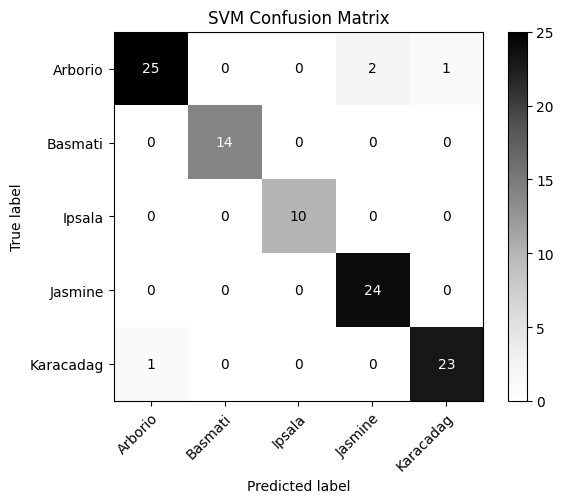

In [40]:
y_pred_svm = svm.predict(X_test)

cm = confusion_matrix(y_test, y_pred_svm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Grays)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.title("SVM Confusion Matrix")
plt.show()

## CLASIFICATION REPORT

In [41]:
print("Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

Classification Report:
              precision    recall  f1-score   support

     Arborio       0.96      0.89      0.93        28
     Basmati       1.00      1.00      1.00        14
      Ipsala       1.00      1.00      1.00        10
     Jasmine       0.92      1.00      0.96        24
   Karacadag       0.96      0.96      0.96        24

    accuracy                           0.96       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.96      0.96      0.96       100



## TEST MODEL

In [48]:
original_dataset_dir = 'D:/SEMESTER 6/VISIKOM/New folder/Rice_Image_Dataset'
test_dir = 'D:/SEMESTER 6/VISIKOM/test'
import random
import shutil
os.makedirs(test_dir, exist_ok=True)

test_ratio = 0.2

for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    images = os.listdir(class_dir)
    random.shuffle(images)
    split_index = int(len(images) * test_ratio)

    test_images = images[:split_index]

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_dir, class_name, img)
        shutil.copy2(src, dst)

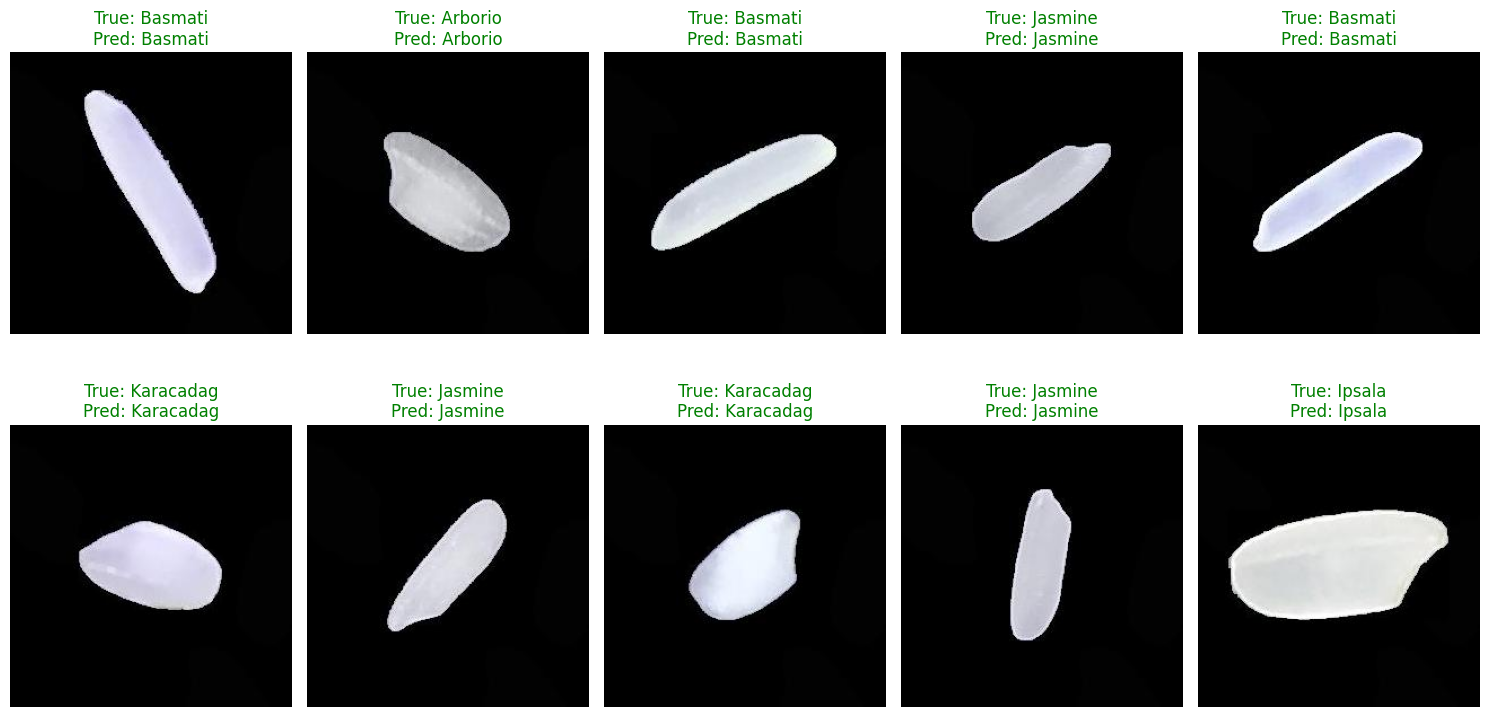

In [49]:
def visualize_sample_predictions(model, folder_path, label_encoder, scaler, num_samples=5):
    image_paths = []
    labels = []

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(img_path)
                labels.append(class_name)

    if num_samples > len(image_paths):
        num_samples = len(image_paths)
        print(f"Hanya {num_samples} gambar yang tersedia, menyesuaikan jumlah sampel.")

    indices = np.random.choice(len(image_paths), num_samples, replace=False)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        img_path = image_paths[idx]
        true_label = labels[idx]

        image = cv2.imread(img_path)
        if image is None:
            print(f"Gagal membaca gambar: {img_path}")
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        feature = extract_hog_features(image)
        feature = scaler.transform([feature])
        pred = model.predict(feature)[0]
        pred_label = label_encoder.inverse_transform([pred])[0]

        plt.subplot(2, 5, i + 1)
        plt.imshow(image_rgb)
        plt.title(f"True: {true_label}\nPred: {pred_label}",
                  color='green' if true_label == pred_label else 'red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_sample_predictions(svm, test_dir, le, scaler, num_samples=10)